In [1]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

In [4]:
from keras.datasets import mnist

In [15]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## 1. Load Dataset

### 1) MNIST Dataset

In [5]:
(X_train, y_train) , (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [7]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### 2) 'mnist_32.csv' Data
- AutoEncoder 'Latent Space' Data

In [8]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/mnist_32.csv'
mnist_32 = pd.read_csv(url)

mnist_32.shape

(10000, 32)

In [9]:
mnist_32.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,3.688405,3.930005,9.707697,11.878195,8.254636,5.676317,17.008430,5.514244,-0.829364,7.013071,3.751570,2.169409,4.598038,12.913482,8.472067,4.234409,5.188710,3.429921,4.983205,4.353836,-0.879628,4.990164,-0.934536,6.870015,12.158235,13.716932,8.344388,13.778448,-0.989779,-0.983739,4.144263,12.360807
1,8.770631,13.023509,8.275418,10.167507,4.191549,8.799183,7.692517,14.583757,-0.964878,9.153512,4.790013,9.986683,19.640018,6.880817,14.399618,7.320549,4.496984,7.699464,12.053535,9.095699,-0.984573,5.103552,-0.628069,16.332850,14.312974,10.023836,8.879703,4.838847,-0.999356,-0.976225,6.888207,5.912664
2,3.612655,4.127336,6.994210,11.199030,4.834584,2.894823,7.723920,3.293408,0.018939,2.376893,3.089628,11.087647,11.132550,12.738778,10.536118,3.589839,7.429894,1.177265,9.637258,4.312238,-0.964384,0.562908,-0.839960,8.922295,3.176869,3.251928,10.095084,2.780117,-0.962890,-0.873302,4.892313,3.869293
3,4.778088,11.318460,19.590998,9.894455,8.185436,5.662807,9.577927,10.103026,-0.990062,15.396132,4.704505,6.508475,13.564884,9.256410,15.270179,3.763558,5.041377,7.311136,10.487534,6.901152,-0.994324,6.308151,-0.950087,7.890187,9.783769,11.231997,4.084829,17.978115,-0.999962,-0.998608,9.772373,9.696581
4,4.581480,6.314673,9.630608,5.819597,4.213900,6.164255,1.878163,4.087563,-0.712614,15.693965,2.012676,1.536107,4.594669,6.296140,7.781682,5.580368,11.212196,3.216171,10.723434,4.829007,-0.997158,8.401155,-0.781293,4.067109,4.883681,11.075063,8.700143,14.223484,-0.990151,-0.995499,8.750870,12.275040


## 2. K-Means Clusetering

### 1) Modeling - sklearn.cluster

In [11]:
clusters = KMeans(n_clusters = 10, # 10000 개를 10개로 묶어보자!
                  n_init = 10,
                  random_state = 2045)

clusters.fit(mnist_32)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2045, tol=0.0001, verbose=0)

### 2) Visualization
- Clusters.labels_: 0부터 9까지 10개의 군집 정보
  - 각 군집에 속한 이미지 시각화
  - 'X_test' Data 사용

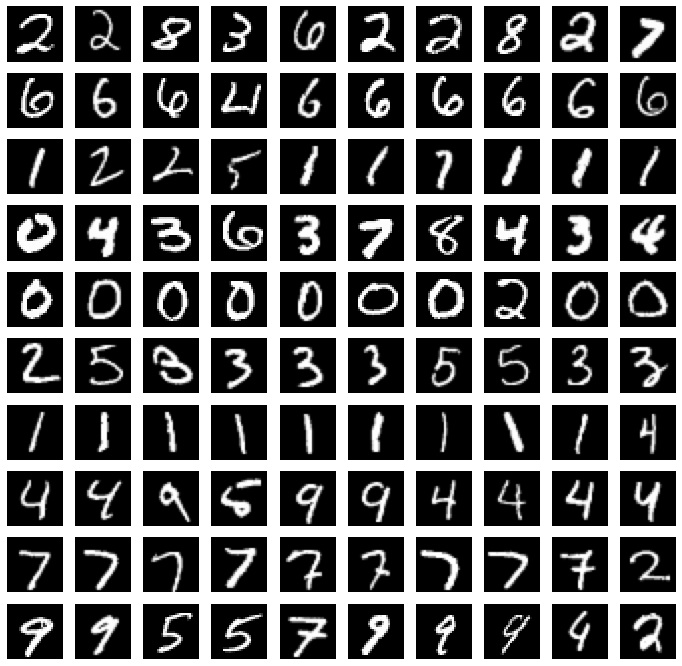

In [14]:
plt.figure(figsize = (12, 12))

for i in range(10) :
  images = X_test[clusters.labels_ == i]
  for n in range(10) :
    plt.subplot(10, 10, i * 10 + n + 1)
    plt.imshow(images[n].reshape(28, 28), cmap = 'gray')
    plt.axis('off')

plt.show()


# 그룹별로 비슷하게 묶여있을까? (latent space가 제대로 구분되었을까?)
# 32개의 특징을 가지고 비지도학습 알고리즘을 돌려보니, 명확하게 구별되지는 않는 것 같다
# k-means clustering의 성능이 좋지않아서

## 3. t-SNE(Stochastic Neighbor Embedding)
- 각 데이터의 유사도를 확률적(Stochastic)으로 표현
- 하나의 데이터로부터 다른 데이터에 대한 거리를 't-분포'의 확률로 치환
  - 가까운 거리의 데이터는 높은 확률값
  - 먼 거리의 데이터는 낮은 확률값
  - https://bcho.tistory.com/1210
- 고차원과 저차원에서 확률값을 계산 후, 저차원 확률값이 고차원에 가까워지도록 학습
- 연산에 많은 시간이 걸리기 때문에 50차원 이하의 데이터 사용을 권장
  - 32차원의 'mnist_32.csv' Data

### 1) Modeling - sklearn.manifold
- 약 2분

- n_components: 축소 차원 공간
- learning_rate: 학습률(10 ~ 1000)
- perplexity: 고려할 최근접 이웃의 숫자(5 ~ 50)

In [16]:
tsne = TSNE(n_components = 2,
            learning_rate = 100,
            perplexity = 15,      # perplexity에 따라 성능이 달라진다
            random_state = 2045)

tsne_vector = tsne.fit_transform(mnist_32)

- 2차원 정보로 축소

In [17]:
tsne_vector.shape

(10000, 2)

### 2) Visualization
- tsne_vector: 2차원 축소 정보
  - label 별로 잘 뭉쳐있는 것을 확인
  - 'y_test' Data 사용

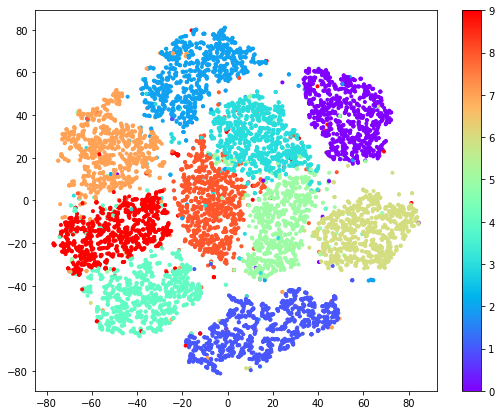

In [18]:
plt.figure(figsize = (9, 7))

fig = plt.scatter(tsne_vector[:, 0],
                  tsne_vector[:, 1],
                  marker = '.',
                  c = y_test,
                  cmap = 'rainbow')
cb = plt.colorbar(fig, ticks = range(10))

plt.show()

- 'y_test' 정보와 비교

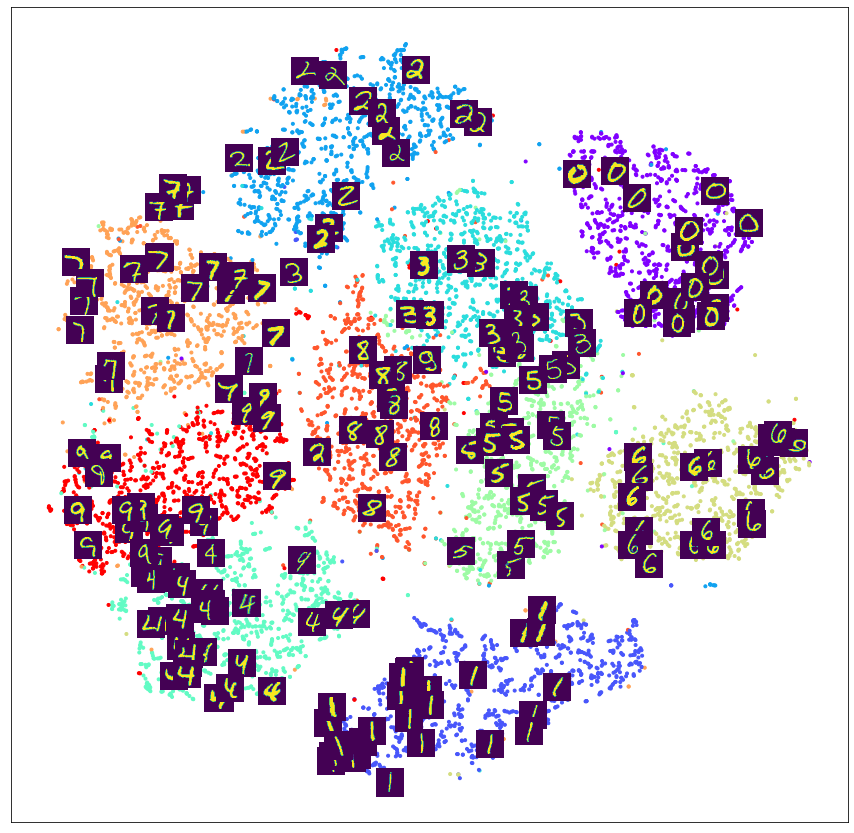

In [20]:
plt.figure(figsize = ( 15, 15))

ax = plt.subplot(1, 1, 1)
ax.scatter(tsne_vector[:, 0],
           tsne_vector[:, 1],
           marker = '.',
           c = y_test,
           cmap = 'rainbow')

for i in range(200):
  imagebox = OffsetImage(X_test[i].reshape(28, 28))
  ab = AnnotationBbox(imagebox,
                      (tsne_vector[i, 0], tsne_vector[i, 1]),
                      frameon = False,
                      pad = 0.0)
  ax.add_artist(ab)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

### 3) 'perplexity'별 결과 비교
- 약 11분
- perplexity: 고려할 최근접 이웃의 숫자(5 ~ 50)
  - 'perplexity' 변화에 따른 군집형태 확인
  - 'y_test' Data 사용

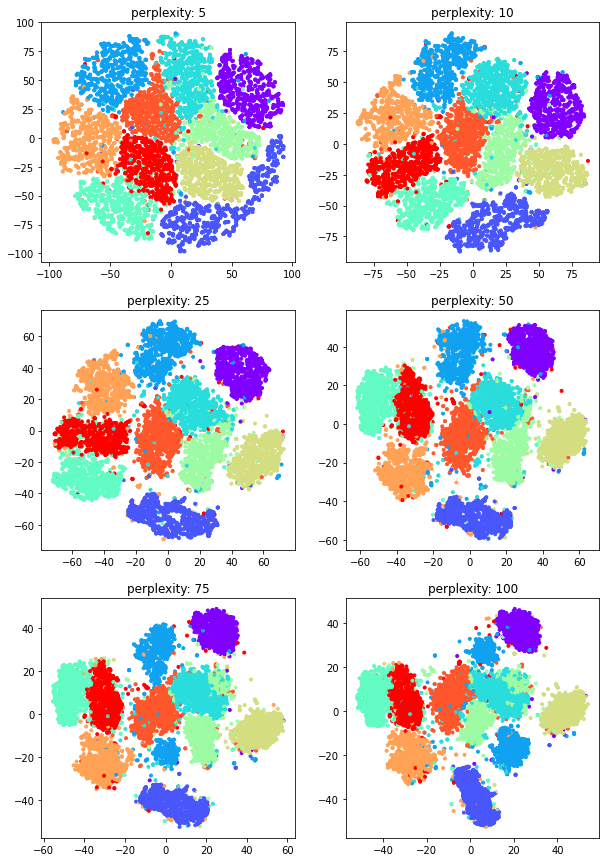

CPU times: user 19min 10s, sys: 2.73 s, total: 19min 13s
Wall time: 10min 6s


In [21]:
%%time

perplexities = [5, 10, 25, 50, 75, 100]

plt.figure(figsize = (10, 15))

for i in range(6) :
  tsne = TSNE(n_components = 2,
              learning_rate = 100,
              perplexity = perplexities[i],
              random_state = 2045)
  
  tsne_vector = tsne.fit_transform(mnist_32)

  plt.subplot(3, 2, i + 1)
  plt.scatter(tsne_vector[:, 0],
              tsne_vector[:, 1],
              marker = '.',
              c = y_test,
              cmap = 'rainbow')
  plt.title('perplexity: {0}' .format(perplexities[i]))

plt.show()